In [1]:
#Team Name: Team 4: The Data Sleuth
#Members: Kimberly Welch
#Date: 10/4/24

In [2]:
# Load necessary libraries
if (!require("gbm")) install.packages("gbm", dependencies = TRUE)
if (!require("caret")) install.packages("caret", dependencies = TRUE)
if (!require("tidyverse")) install.packages("tidyverse", dependencies = TRUE)
if (!require("corrplot")) install.packages("corrplot", dependencies = TRUE)

library(gbm)
library(caret)
library(tidyverse)
library(corrplot)

# Load the data
train_data <- read.csv("train.csv", row.names = "Id", stringsAsFactors = FALSE)
test_data <- read.csv("test.csv", row.names = "Id", stringsAsFactors = FALSE)

# Convert character variables to factors
train_data <- train_data %>%
  mutate_if(is.character, as.factor)

test_data <- test_data %>%
  mutate_if(is.character, as.factor)

# Separate features and target variable
X_train <- train_data %>% select(-SalePrice)
y <- train_data$SalePrice

# Concatenate train and test data for consistent preprocessing
X <- rbind(X_train, test_data)

# Check the structure and summary of data
cat("Train data's size:", dim(X_train), "\n")
cat("Test data's size:", dim(test_data), "\n")

# Identify numerical and categorical columns
numCols <- X_train %>% select(where(is.numeric)) %>% colnames()
catCols <- X_train %>% select(where(is.factor)) %>% colnames()

cat("There are", length(numCols), "numerical features:\n", numCols, "\n")
cat("There are", length(catCols), "categorical features:\n", catCols, "\n")


Loading required package: gbm

Loaded gbm 2.2.2

This version of gbm is no longer under development. Consider transitioning to gbm3, https://github.com/gbm-developers/gbm3

Loading required package: caret

Loading required package: ggplot2

Loading required package: lattice

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ purrr::lift()   masks caret::lift()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: corrplot

corrplot 0.94 loaded



Train data's size: 949 79 
Test data's size: 500 79 
There are 36 numerical features:
 MSSubClass LotFrontage LotArea OverallQual OverallCond YearBuilt YearRemodAdd MasVnrArea BsmtFinSF1 BsmtFinSF2 BsmtUnfSF TotalBsmtSF X1stFlrSF X2ndFlrSF LowQualFinSF GrLivArea BsmtFullBath BsmtHalfBath FullBath HalfBath BedroomAbvGr KitchenAbvGr TotRmsAbvGrd Fireplaces GarageYrBlt GarageCars GarageArea WoodDeckSF OpenPorchSF EnclosedPorch X3SsnPorch ScreenPorch PoolArea MiscVal MoSold YrSold 
There are 43 categorical features:
 MSZoning Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2 Heating HeatingQC CentralAir Electrical KitchenQual Functional FireplaceQu GarageType GarageFinish GarageQual GarageCond PavedDrive PoolQC Fence MiscFeature SaleType SaleCondition 


Skewness: 1.701346 
Kurtosis: 5.644091 


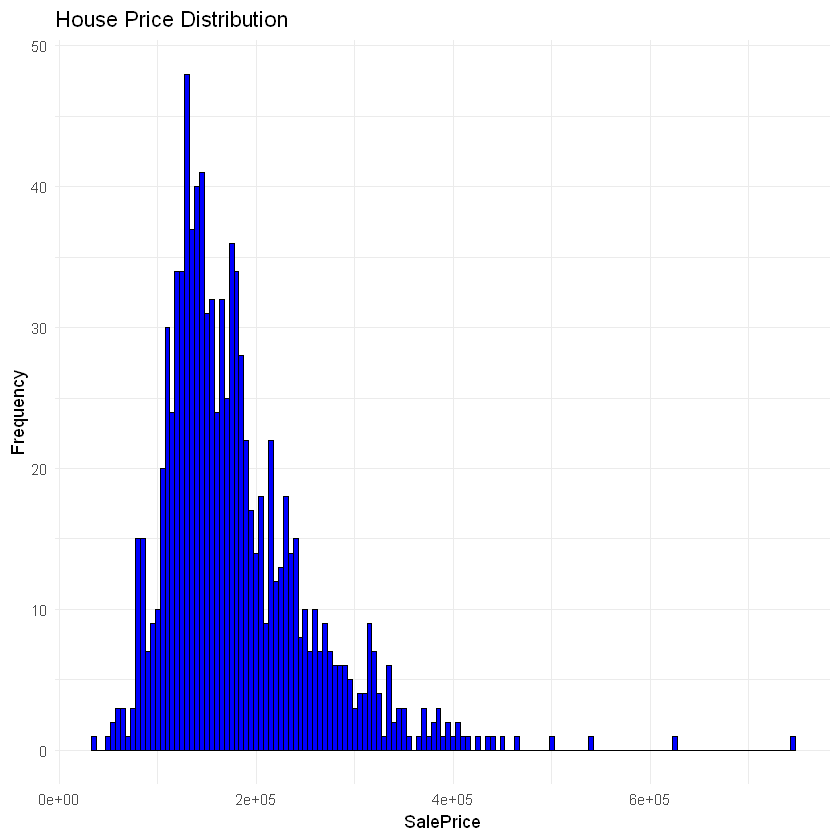

In [3]:
# Visualize SalePrice distribution
ggplot(train_data, aes(x = SalePrice)) +
  geom_histogram(binwidth = 5000, fill = "blue", color = "black") +
  labs(title = "House Price Distribution", x = "SalePrice", y = "Frequency") +
  theme_minimal()

# Check skewness and kurtosis of SalePrice
skewness <- e1071::skewness(y)
kurtosis <- e1071::kurtosis(y)
cat("Skewness:", skewness, "\n")
cat("Kurtosis:", kurtosis, "\n")


Skewness after log transformation: 0.1633782 
Kurtosis after log transformation: 0.4598934 


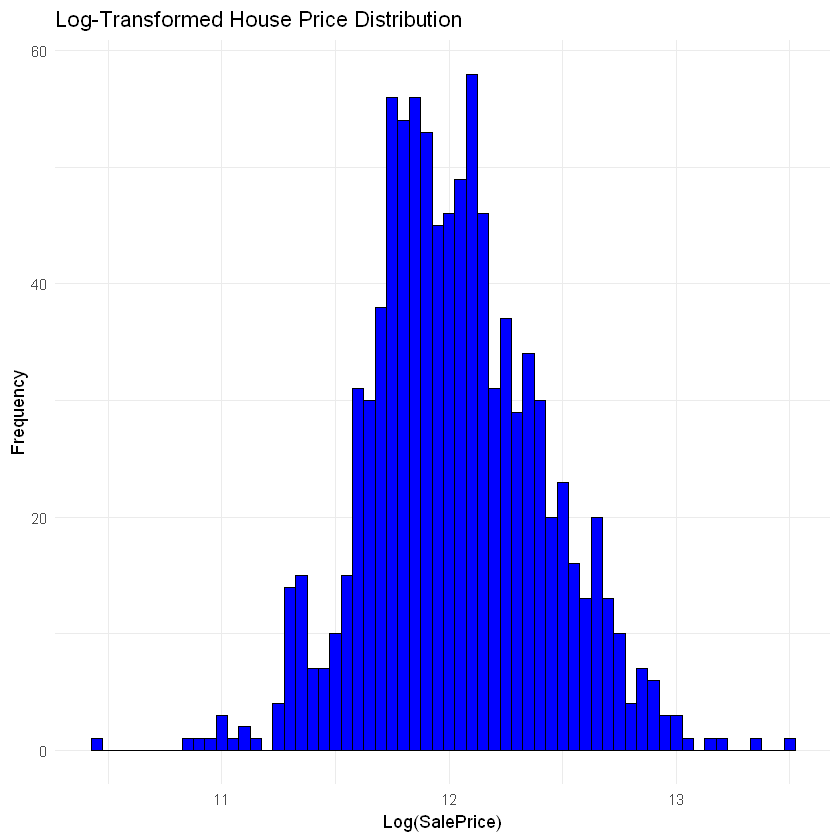

In [4]:
#Adressing the skewness with log transformations
# Log-transform SalePrice
train_data$LogSalePrice <- log(train_data$SalePrice)

# Visualize the transformed SalePrice distribution
ggplot(train_data, aes(x = LogSalePrice)) +
  geom_histogram(binwidth = 0.05, fill = "blue", color = "black") +
  labs(title = "Log-Transformed House Price Distribution", x = "Log(SalePrice)", y = "Frequency") +
  theme_minimal()

# Check skewness and kurtosis after transformation
log_skewness <- e1071::skewness(train_data$LogSalePrice)
log_kurtosis <- e1071::kurtosis(train_data$LogSalePrice)
cat("Skewness after log transformation:", log_skewness, "\n")
cat("Kurtosis after log transformation:", log_kurtosis, "\n")



Top 10 features most correlated with LogSalePrice:
 OverallQual    GrLivArea   GarageCars   GarageArea  TotalBsmtSF    X1stFlrSF 
   0.8281688    0.7070671    0.6658233    0.6396389    0.6378122    0.6084442 
    FullBath    YearBuilt YearRemodAdd  GarageYrBlt 
   0.5998919    0.5922298    0.5920084    0.5661926 


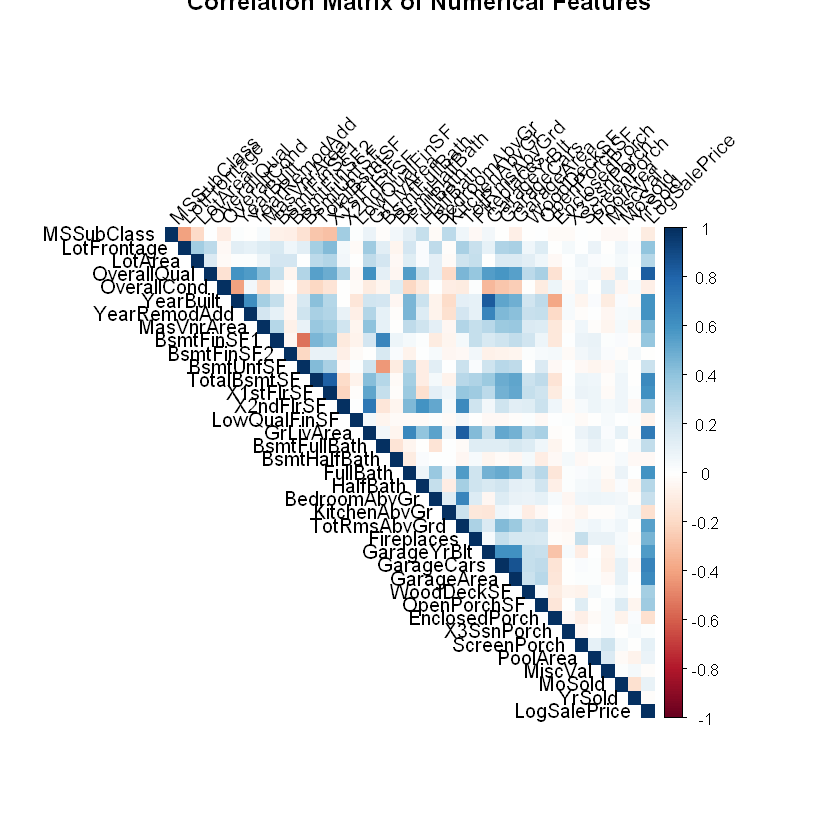

In [5]:
# Select numerical features excluding SalePrice
numeric_data <- train_data %>% select(where(is.numeric), -SalePrice)

# Calculate the correlation matrix using complete observations
corr_mat <- cor(numeric_data, use = "complete.obs")

# Plot the correlation matrix
corrplot(corr_mat, method = "color", type = "upper", tl.col = "black", tl.srt = 45,
         title = "Correlation Matrix of Numerical Features")

# Identify the top 10 features most correlated with LogSalePrice
top_corr_log <- sort(corr_mat[,"LogSalePrice"], decreasing = TRUE)[2:11]

# Print the top 10 correlated features with LogSalePrice
cat("Top 10 features most correlated with LogSalePrice:\n")
print(top_corr_log)


In [6]:
# Summarize each categorical variable in the dataset
categorical_summary <- X_train %>%
  select(where(is.factor)) %>%
  map2_dfr(names(.), function(col_data, col_name) {
    data.frame(
      variable = col_name,                        # Correctly assign the column name
      unique_values = length(unique(col_data)),   # Count unique values
      missing_count = sum(is.na(col_data))        # Count missing values
    )
  })

print(categorical_summary)


        variable unique_values missing_count
1       MSZoning             5             0
2         Street             2             0
3          Alley             3           900
4       LotShape             4             0
5    LandContour             4             0
6      Utilities             1             0
7      LotConfig             5             0
8      LandSlope             3             0
9   Neighborhood            24             0
10    Condition1             8             0
11    Condition2             7             0
12      BldgType             5             0
13    HouseStyle             8             0
14     RoofStyle             6             0
15      RoofMatl             6             0
16   Exterior1st            15             0
17   Exterior2nd            16             0
18    MasVnrType             5             6
19     ExterQual             4             0
20     ExterCond             4             0
21    Foundation             6             0
22      Bs

In [7]:
# Load necessary libraries
if (!require("mice")) install.packages("mice", dependencies = TRUE)
library(mice)

# Load the data (update the file paths to your working directory)
train <- read.csv("train.csv")
test <- read.csv("test.csv")

# Ensure that train and test have the same columns
common_columns <- intersect(names(train), names(test))
train <- train[, common_columns]
test <- test[, common_columns]

# Combine train and test data for consistent preprocessing
combined_data <- rbind(train, test)

# Apply MICE imputation on the combined dataset, suppressing iteration logs
imputed_combined <- mice(combined_data, method = 'pmm', m = 5, printFlag = FALSE)  # 'pmm' is predictive mean matching
combined_mice <- complete(imputed_combined)

# Split the imputed data back into train and test sets
train_mice <- combined_mice[1:nrow(train), ]
test_mice <- combined_mice[(nrow(train) + 1):nrow(combined_mice), ]



Loading required package: mice


Attaching package: 'mice'


The following object is masked from 'package:stats':

    filter


The following objects are masked from 'package:base':

    cbind, rbind


Warning message:
"Number of logged events: 160"


In [8]:
# Function to handle categorical variables consistently between train and test
handle_categorical <- function(train_data, test_data, variable, fill_value = NA) {
  # Define levels based on the training data
  levels_train <- unique(c(levels(as.factor(train_data[[variable]])), as.character(fill_value)))
  
  # Set the factor levels in training data
  train_data[[variable]] <- factor(train_data[[variable]], levels = levels_train)
  
  # Set the factor levels in test data with the same levels
  test_data[[variable]] <- factor(test_data[[variable]], levels = levels_train)
  
  # Fill missing values in test data if a fill_value is specified and exists within levels
  if (!is.na(fill_value) && fill_value %in% levels_train) {
    test_data[[variable]][is.na(test_data[[variable]])] <- fill_value
  }
  
  return(list(train = train_data, test = test_data))
}

# Handle categorical variables with specified fill values
categorical_vars <- c("Neighborhood", "SaleType", "PoolQC", "BldgType", "LotConfig", "CentralAir")
fill_values <- c("Most_Common", "Most_Common", "NoPool", NA, NA, NA)

# Apply handling function to each categorical variable
for (i in seq_along(categorical_vars)) {
  cat_var <- categorical_vars[i]
  fill_value <- fill_values[i]
  
  # Check if fill_value is not NA before comparing
  if (!is.na(fill_value) && fill_value == "Most_Common") {
    # Handle the "Most_Common" case separately
    most_common <- names(which.max(table(train_mice[[cat_var]])))
    train_mice[[cat_var]] <- factor(train_mice[[cat_var]], levels = unique(c(levels(train_mice[[cat_var]]), most_common)))
    test_mice[[cat_var]] <- factor(test_mice[[cat_var]], levels = levels(train_mice[[cat_var]]))
    test_mice[[cat_var]][is.na(test_mice[[cat_var]])] <- most_common
  } else {
    # Use the general function for other fill values
    result <- handle_categorical(train_mice, test_mice, cat_var, fill_value)
    train_mice <- result$train
    test_mice <- result$test
  }
}

# Additional code to create new features and check the dataset structure remains the same


In [9]:
# Create new features with robust checks
create_features <- function(data) {
  # Adding log transformation for LotArea
  data$LogLotArea <- log(data$LotArea)

  # Create TotalBath feature
  data$TotalBath <- data$FullBath + 0.5 * data$HalfBath + 
    data$BsmtFullBath + 0.5 * data$BsmtHalfBath

  # New Feature: Total square feet (above ground and basement)
  data$TotalSqFt <- data$GrLivArea + data$TotalBsmtSF

  # New Feature: Age of the house
  data$HouseAge <- data$YrSold - data$YearBuilt

  # New Feature: Whether the house was remodeled
  data$Remodeled <- ifelse(data$YearRemodAdd != data$YearBuilt, 1, 0)

  # New Feature: Whether the house was sold in the same year it was built
  data$SoldSameYearBuilt <- ifelse(data$YearBuilt == data$YrSold, 1, 0)

  # Total Porch Area
  data$TotalPorchArea <- data$OpenPorchSF + data$EnclosedPorch + data$X3SsnPorch + data$ScreenPorch

  # Has Garage - Update to handle NAs correctly with robust checks
  if ("GarageType" %in% names(data)) {
    # Debugging information to help identify issues
    print(paste("Initial rows:", nrow(data)))
    print(paste("Rows with missing GarageType:", sum(is.na(data$GarageType))))

    # Proper handling of HasGarage
    data$HasGarage <- ifelse(is.na(data$GarageType), 0, 1)
    print(paste("Rows with HasGarage assigned:", sum(!is.na(data$HasGarage))))
    print(paste("Unique values in HasGarage:", unique(data$HasGarage)))
  } else {
    stop("GarageType column is missing from the data.")
  }

  return(data)
}

# Apply feature creation to train and test mice data
train_mice <- create_features(train_mice)
test_mice <- create_features(test_mice)

# Add SalePrice and LogSalePrice if they exist in the train data
if ("SalePrice" %in% colnames(train_data)) {
  train_mice$SalePrice <- train_data$SalePrice
  train_mice$LogSalePrice <- log(train_mice$SalePrice)
}

# Verify that LogSalePrice has been correctly added
print(colnames(train_mice))

# Check the structure of the final datasets
str(train_mice)
str(test_mice)


[1] "Initial rows: 949"
[1] "Rows with missing GarageType: 43"
[1] "Rows with HasGarage assigned: 949"
[1] "Unique values in HasGarage: 0" "Unique values in HasGarage: 1"
[1] "Initial rows: 500"
[1] "Rows with missing GarageType: 35"
[1] "Rows with HasGarage assigned: 500"
[1] "Unique values in HasGarage: 1" "Unique values in HasGarage: 0"
 [1] "Id"                "MSSubClass"        "MSZoning"         
 [4] "LotFrontage"       "LotArea"           "Street"           
 [7] "Alley"             "LotShape"          "LandContour"      
[10] "Utilities"         "LotConfig"         "LandSlope"        
[13] "Neighborhood"      "Condition1"        "Condition2"       
[16] "BldgType"          "HouseStyle"        "OverallQual"      
[19] "OverallCond"       "YearBuilt"         "YearRemodAdd"     
[22] "RoofStyle"         "RoofMatl"          "Exterior1st"      
[25] "Exterior2nd"       "MasVnrType"        "MasVnrArea"       
[28] "ExterQual"         "ExterCond"         "Foundation"       
[31] "Bs

In [10]:
# Updated imputation function to handle missing categorical variables and remove single-level factors
categorical_impute <- function(data) {
  # Define the variables that need "None" as a missing value replacement
  factor_vars <- c("Alley", "PoolQC", "Fence", "MiscFeature", "BsmtQual", 
                   "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
                   "GarageType", "GarageFinish", "GarageQual", "GarageCond", "FireplaceQu", 
                   "MasVnrType")
  
  # Ensure "None" is a valid level for each variable and handle missing values
  for (var in factor_vars) {
    if (var %in% names(data)) {
      if (!"None" %in% levels(data[[var]])) {
        data[[var]] <- factor(data[[var]], levels = c(levels(data[[var]]), "None"))
      }
      # Impute missing values with "None" if the column is not empty
      if (nrow(data[!is.na(data[[var]]), ]) > 0) {
        data[[var]][is.na(data[[var]])] <- "None"
      }
    }
  }
  
  # Impute 'Electrical' with the most common value (mode)
  if ("Electrical" %in% names(data)) {
    mode_electrical <- names(which.max(table(data$Electrical)))
    data$Electrical[is.na(data$Electrical)] <- mode_electrical
  }
  
  # Identify and remove single-level factors
  single_level_factors <- sapply(data, function(x) is.factor(x) && length(unique(x)) == 1)
  removed_factors <- names(single_level_factors[single_level_factors])
  data <- data[, !single_level_factors]
  
  cat("Removed single-level factors:", removed_factors, "\n")
  
  return(data)
}

# Apply the updated imputation function to the train and test datasets
updated_train_mice <- categorical_impute(train_mice)
updated_test_mice <- categorical_impute(test_mice)

# Re-check missing values to confirm imputation
missing_summary_after <- colSums(is.na(updated_train_mice))
missing_summary_after <- missing_summary_after[missing_summary_after > 0]
print(missing_summary_after) # Should show no missing values

# Assign updated datasets back to train_mice and test_mice if necessary
train_mice <- updated_train_mice
test_mice <- updated_test_mice


Removed single-level factors: Alley MasVnrType BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2 FireplaceQu GarageType GarageFinish GarageQual GarageCond Fence MiscFeature 
Removed single-level factors: Alley Neighborhood MasVnrType BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2 FireplaceQu GarageType GarageFinish GarageQual GarageCond Fence MiscFeature SaleType 
Neighborhood     SaleType 
         798          117 


In [11]:
#Skewness
# Load necessary library
if (!require("e1071")) install.packages("e1071", dependencies = TRUE)
library(e1071)

# Calculate skewness for numerical features
numeric_features <- train_mice %>% select(where(is.numeric))
skew_values <- sapply(numeric_features, skewness, na.rm = TRUE)

# Identify features with high skewness
high_skew <- skew_values[abs(skew_values) > 0.75]
print(high_skew)



Loading required package: e1071



       MSSubClass       LotFrontage           LotArea        MasVnrArea 
        1.4152865         1.0767307        12.1305623         2.7551450 
       BsmtFinSF1        BsmtFinSF2         BsmtUnfSF         X1stFlrSF 
        0.7529125         4.4526072         0.9616655         0.8882562 
        X2ndFlrSF      LowQualFinSF         GrLivArea      BsmtHalfBath 
        0.8274332        10.0508547         1.0904108         4.2649923 
     KitchenAbvGr        WoodDeckSF       OpenPorchSF     EnclosedPorch 
        4.3521091         1.6096722         2.2974721         2.9017995 
       X3SsnPorch       ScreenPorch          PoolArea           MiscVal 
       10.1789533         3.9430836        15.4396599        19.9291800 
        TotalSqFt SoldSameYearBuilt    TotalPorchArea         HasGarage 
        0.9483656         4.5501009         2.0837858        -4.3654162 
        SalePrice 
        1.7013460 


In [12]:

# Function to ensure numeric features are properly formatted
numeric_transform <- function(data, feature) {
  # Convert to numeric if not already
  data[[feature]] <- as.numeric(as.character(data[[feature]]))
  return(data)
}

# List of skewed features identified earlier
skewed_features <- c("MSSubClass", "LotFrontage", "LotArea", "MasVnrArea", 
                     "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "X1stFlrSF", 
                     "X2ndFlrSF", "LowQualFinSF", "GrLivArea", "BsmtHalfBath", 
                     "KitchenAbvGr", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", 
                     "X3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal", 
                     "TotalSqFt", "SoldSameYearBuilt", "TotalPorchArea", 
                     "HasGarage")

# Convert relevant features to numeric in both train_mice and test_mice datasets
for (feature in skewed_features) {
  train_mice <- numeric_transform(train_mice, feature)
  test_mice <- numeric_transform(test_mice, feature)
}

# Apply transformations to reduce skewness
for (feature in skewed_features) {
  if (all(train_mice[[feature]] > 0, na.rm = TRUE)) {
    # Use log1p for positive, highly skewed data
    train_mice[[feature]] <- log1p(train_mice[[feature]])
    test_mice[[feature]] <- log1p(test_mice[[feature]])
  } else if (all(train_mice[[feature]] >= 0, na.rm = TRUE)) {
    # Use sqrt for moderately skewed data with zeros
    train_mice[[feature]] <- sqrt(train_mice[[feature]])
    test_mice[[feature]] <- sqrt(test_mice[[feature]])
  } else {
    # Handle cases with negative values carefully; alternative could be no transformation
    train_mice[[feature]] <- scale(train_mice[[feature]], center = TRUE, scale = TRUE)
    test_mice[[feature]] <- scale(test_mice[[feature]], center = TRUE, scale = TRUE)
  }
}

# Recalculate skewness to assess the effect of transformations
new_skew_values <- sapply(train_mice %>% select(all_of(skewed_features)), skewness, na.rm = TRUE)
print(new_skew_values)


       MSSubClass       LotFrontage           LotArea        MasVnrArea 
       0.26999655       -0.70696719        0.10587744        1.03080818 
       BsmtFinSF1        BsmtFinSF2         BsmtUnfSF         X1stFlrSF 
      -0.15085171        3.16574367       -0.20044015        0.01718937 
        X2ndFlrSF      LowQualFinSF         GrLivArea      BsmtHalfBath 
       0.44187233        8.87824659       -0.02319685        3.95931885 
     KitchenAbvGr        WoodDeckSF       OpenPorchSF     EnclosedPorch 
       2.40517465        0.52619789        0.61997801        2.36050075 
       X3SsnPorch       ScreenPorch          PoolArea           MiscVal 
       7.93254805        3.17968103       15.31990338        8.61315415 
        TotalSqFt SoldSameYearBuilt    TotalPorchArea         HasGarage 
      -0.31404968        4.55010089        0.32001950       -4.36541621 


In [13]:
# Step 1: Re-check the available numeric columns in both datasets
numeric_features_train <- train_mice %>% select(where(is.numeric))
numeric_features_test <- test_mice %>% select(where(is.numeric))

# Ensure both datasets have the same columns by intersecting their column names
common_columns <- intersect(colnames(numeric_features_train), colnames(numeric_features_test))

# Select only the common columns from both datasets
numeric_features_train <- numeric_features_train[, common_columns, drop = FALSE]
numeric_features_test <- numeric_features_test[, common_columns, drop = FALSE]

# Step 2: Check for highly correlated features across the combined data
combined_numeric <- rbind(numeric_features_train, numeric_features_test)
cor_matrix <- cor(combined_numeric, use = "complete.obs")

# Identify and remove highly correlated features if applicable
high_corr <- findCorrelation(cor_matrix, cutoff = 0.9) # Adjust cutoff threshold if needed
selected_numeric_features <- combined_numeric[, -high_corr, drop = FALSE]

# Ensure that at least two columns remain; otherwise, manually adjust the column selection
if (ncol(selected_numeric_features) < 2) {
  cat("Adjusting selection to ensure at least two columns are available...\n")
  
  # Reintroduce essential columns manually if required
  essential_columns <- unique(c(colnames(numeric_features_train), "GrLivArea", "TotalBsmtSF")) # Adjust as needed
  selected_numeric_features <- combined_numeric[, essential_columns, drop = FALSE]
  
  # Ensure columns are still consistent between train and test
  common_selected_columns <- intersect(colnames(selected_numeric_features), colnames(combined_numeric))
  selected_numeric_features <- selected_numeric_features[, common_selected_columns, drop = FALSE]
}

# Step 3: Check and bind adjusted data
train_selected <- selected_numeric_features[1:nrow(numeric_features_train), , drop = FALSE]
test_selected <- selected_numeric_features[(nrow(numeric_features_train) + 1):nrow(selected_numeric_features), , drop = FALSE]

# Combine the adjusted train and test data
combined_data_adj <- rbind(train_selected, test_selected)

# Verify column consistency before imputation
cat("Columns in adjusted data for imputation:", colnames(combined_data_adj), "\n")
cat("Number of columns in adjusted data:", ncol(combined_data_adj), "\n")

# Step 4: Perform imputation if conditions are met
if (ncol(combined_data_adj) >= 2) {
  imputed_combined <- mice(combined_data_adj, method = 'pmm', m = 5, printFlag = FALSE)
} else {
  stop("Insufficient columns for imputation. Please adjust the column selection process.", call. = FALSE)
}

# Split imputed data back into train and test sets
combined_mice <- complete(imputed_combined)
train_mice <- combined_mice[1:nrow(train), ]
test_mice <- combined_mice[(nrow(train) + 1):nrow(combined_mice), ]


Columns in adjusted data for imputation: Id MSSubClass LotFrontage OverallQual OverallCond YearBuilt YearRemodAdd MasVnrArea BsmtFinSF1 BsmtFinSF2 BsmtUnfSF TotalBsmtSF X1stFlrSF X2ndFlrSF LowQualFinSF GrLivArea BsmtFullBath BsmtHalfBath FullBath HalfBath BedroomAbvGr KitchenAbvGr TotRmsAbvGrd Fireplaces GarageYrBlt GarageCars GarageArea WoodDeckSF OpenPorchSF EnclosedPorch X3SsnPorch ScreenPorch PoolArea MiscVal MoSold YrSold LogLotArea TotalBath TotalSqFt Remodeled SoldSameYearBuilt TotalPorchArea HasGarage 
Number of columns in adjusted data: 43 


In [14]:
# Step 4: Perform imputation using MICE with predictive mean matching (pmm)
imputed_combined <- mice(combined_data_adj, method = 'pmm', m = 5, printFlag = FALSE)

# Check imputation logs for any warnings or errors
if (!is.null(imputed_combined$loggedEvents) && nrow(imputed_combined$loggedEvents) > 0) {
  cat("Warning: Issues were logged during MICE imputation. Review the logged events for details.\n")
  print(imputed_combined$loggedEvents)
}

# Step 5: Complete the imputation to get the imputed dataset
combined_mice <- complete(imputed_combined)

# Step 6: Split the imputed data back into training and test sets
train_mice <- combined_mice[1:nrow(train), ]
test_mice <- combined_mice[(nrow(train) + 1):nrow(combined_mice), ]

# Verify the structure and check for remaining missing values in both datasets
cat("Remaining missing values in train set after imputation:\n")
print(colSums(is.na(train_mice)))

cat("Remaining missing values in test set after imputation:\n")
print(colSums(is.na(test_mice)))


Remaining missing values in train set after imputation:
               Id        MSSubClass       LotFrontage       OverallQual 
                0                 0                 0                 0 
      OverallCond         YearBuilt      YearRemodAdd        MasVnrArea 
                0                 0                 0                 0 
       BsmtFinSF1        BsmtFinSF2         BsmtUnfSF       TotalBsmtSF 
                0                 0                 0                 0 
        X1stFlrSF         X2ndFlrSF      LowQualFinSF         GrLivArea 
                0                 0                 0                 0 
     BsmtFullBath      BsmtHalfBath          FullBath          HalfBath 
                0                 0                 0                 0 
     BedroomAbvGr      KitchenAbvGr      TotRmsAbvGrd        Fireplaces 
                0                 0                 0                 0 
      GarageYrBlt        GarageCars        GarageArea        WoodDec

In [15]:
# Ensure that SalePrice exists in the original training data
if (!"SalePrice" %in% colnames(train_data)) {
  stop("SalePrice was not found in the original train_data. Ensure that the original data contains SalePrice.")
}

# Add SalePrice back to train_mice from the original data
if (!"SalePrice" %in% colnames(train_mice)) {
  train_mice$SalePrice <- train_data$SalePrice
  message("SalePrice added back to train_mice.")
}

# Calculate LogSalePrice based on SalePrice
if ("SalePrice" %in% colnames(train_mice)) {
  train_mice$LogSalePrice <- log(train_mice$SalePrice)
} else {
  stop("SalePrice was still not found in train_mice. Ensure that it was correctly added.")
}

# Verify that LogSalePrice has been correctly added
if (!"LogSalePrice" %in% colnames(train_mice)) {
  stop("LogSalePrice was not found in train_mice. Ensure that SalePrice exists in the data and LogSalePrice is calculated correctly.")
}

# Re-assign y_train after recalculating LogSalePrice
y_train <- train_mice$LogSalePrice

# Check if y_train now has values
str(y_train)


SalePrice added back to train_mice.



 num [1:949] 11.7 12 11.9 11.9 12.2 ...


In [16]:
predictors <- colnames(train_mice)[!colnames(train_mice) %in% "LogSalePrice"]



Stochastic Gradient Boosting 

949 samples
 43 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 760, 760, 758, 759, 759 
Resampling results across tuning parameters:

  shrinkage  interaction.depth  n.minobsinnode  n.trees  RMSE       Rsquared 
  0.045      3                  13              275      0.1284840  0.8864481
  0.045      3                  13              300      0.1286060  0.8864287
  0.045      3                  13              325      0.1285738  0.8863749
  0.045      3                  13              350      0.1288301  0.8861820
  0.045      3                  14              275      0.1293586  0.8853019
  0.045      3                  14              300      0.1293722  0.8854673
  0.045      3                  14              325      0.1294142  0.8854175
  0.045      3                  14              350      0.1291707  0.8857565
  0.045      3                  15              275      0.1301346  0.8837686
  0.045   

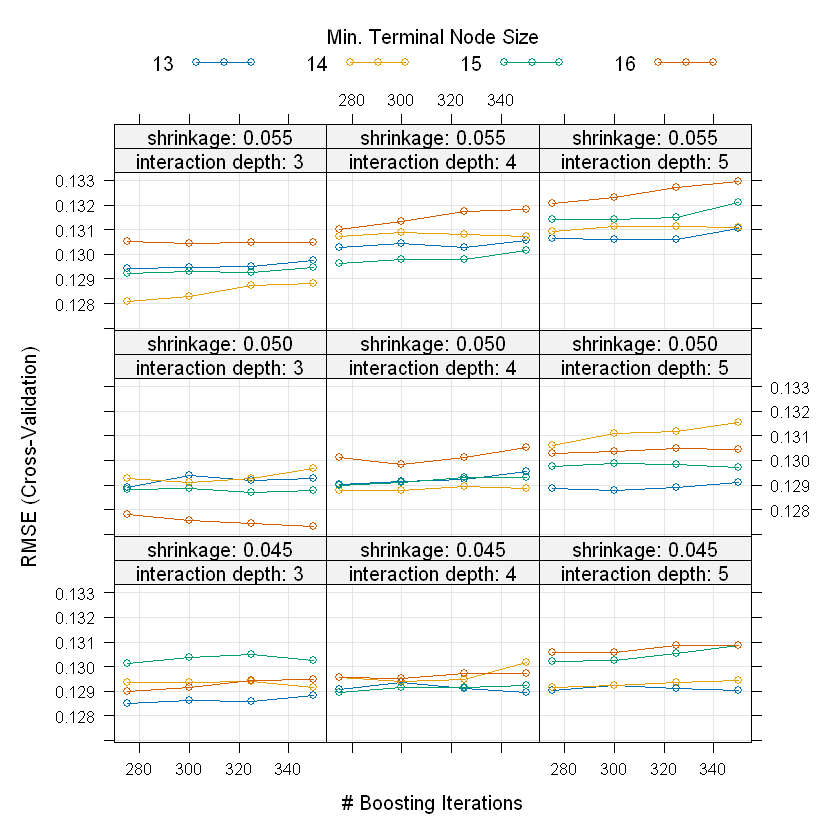

In [17]:
# Define the training control with cross-validation settings
train_control <- trainControl(
  method = "cv",       # Cross-validation
  number = 5,          # Number of folds
  verboseIter = FALSE  # Suppress verbose output
)
# Remove SalePrice and LogSalePrice from predictors
predictors <- setdiff(names(train_mice), c("SalePrice", "LogSalePrice"))

# Extract the predictor data and response variable
x_train <- train_mice[, predictors]
y_train <- train_mice$LogSalePrice

# Define a further refined hyperparameter grid based on the latest results
gbm_grid_refined <- expand.grid(
  n.trees = c(275, 300, 325, 350),           # Extending the range of trees
  interaction.depth = c(3, 4, 5),            # Focused around the optimal depth
  shrinkage = c(0.045, 0.05, 0.055),         # Narrow shrinkage range
  n.minobsinnode = c(13, 14, 15, 16)         # Fine-tuned node sizes around the best
)


# Train the GBM model with the refined hyperparameter grid
gbm_model_refined <- train(
  x = x_train,
  y = y_train,
  method = "gbm",
  trControl = train_control,
  tuneGrid = gbm_grid_refined,
  metric = "RMSE",
  verbose = FALSE
)

# Output and plot the refined model results
print(gbm_model_refined)
plot(gbm_model_refined)


In [ ]:
# Load necessary libraries
if (!require("xgboost")) install.packages("xgboost", dependencies = TRUE)
if (!require("caret")) install.packages("caret", dependencies = TRUE)
if (!require("Matrix")) install.packages("Matrix", dependencies = TRUE)

library(xgboost)
library(caret)
library(Matrix)

# Define training control
train_control <- trainControl(
  method = "cv",       # Cross-validation
  number = 5,          # Number of folds
  verboseIter = FALSE  # Suppress verbose output
)

# Convert dataset to matrix format required by XGBoost
x_train <- as.matrix(train_mice[, predictors])
y_train <- train_mice$LogSalePrice

# Define the hyperparameter grid for XGBoost
xgb_grid <- expand.grid(
  nrounds = c(300, 400, 500),               # Boosting rounds
  max_depth = c(3, 4, 5, 6),                # Tree depth
  eta = c(0.01, 0.03, 0.05, 0.07),          # Learning rate
  gamma = c(0, 0.1, 0.5, 1),                # Minimum loss reduction
  colsample_bytree = c(0.6, 0.8, 1),        # Subsample features
  min_child_weight = c(1, 5, 10),           # Minimum sum of instance weight
  subsample = c(0.6, 0.8, 1.0)              # Subsample data
)

# Train the XGBoost model with the hyperparameter grid
xgb_model_optimized <- train(
  x = x_train,
  y = y_train,
  method = "xgbTree",
  trControl = train_control,
  tuneGrid = xgb_grid,
  metric = "RMSE",
  verbose = FALSE
)

# Output and plot the optimized XGBoost model results
print(xgb_model_optimized)
plot(xgb_model_optimized)


Loading required package: xgboost


Attaching package: 'xgboost'


The following object is masked from 'package:dplyr':

    slice


Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack




In [18]:
# Generate predictions on the test set
test_predictions <- predict(xgb_model_optimized, newdata = test_mice[, predictors])

# Convert LogSalePrice back to SalePrice
predicted_sale_price <- exp(test_predictions)

# Create a submission dataframe with IDs and predicted Sale Prices
submission <- data.frame(
  Id = test_mice$Id, # Assuming 'Id' is the identifier column
  SalePrice = predicted_sale_price
)

# Save the submission file as a CSV
write.csv(submission, 'week_7_pred.csv', row.names = FALSE)

# Print the first few rows of the submission file
head(submission)


,Id,SalePrice
,<int>,<dbl>
1,951,101616.20
2,952,185541.79
3,953,325706.33
4,954,466250.54
5,955,85048.09
6,956,154762.90
